# Development and Nonlinear Buckling Analysis of a CRM-like Box Beam

In all our notebooks so far we have used a box beam geometry with a length-based aspect ratio $AR=l/w=4.5$, so that the aspect ratio based on twice the length, $2l/w$, would be equal to the aspect ratio of the CRM wing, that is to say $9$. However, the wingbox of the CRM wing is much more slender than the wing itself. For this reason, in this notebook we are going to define a box beam geometry more similar to the one of the CRM wingbox, and we'll also investigate its nonlinear buckling behavior.

* [Geometry definition](#geometry)
* [Setup of the numerical model](#numerical-model)
* [Mesh convergence study](#mesh-convergence)
* [Nonlinear analysis: mesh convergence verification](#mesh-verification)
* [Nonlinear analysis: sensitivity of nonlinear analysis parameters](#nonlinear-analysis-parameters)
    * [Error function](#error-function)
    * [Convergence tolerance](#convergence-tolerance)
    * [Initial load increment](#ninc)
    * [Desired number of iteration](#desiter)
    * [Minimum allowable arc-length adjustment ratio](#minalr)
    * [Maximum allowable arc-length adjustment ratio](#maxalr)
* [3D equilibrium diagram](#equilibrium-diagram)
* [Conclusions](#conclusions)

## Geometry definition <a name="geometry"></a>

***

We consider the same kind of straight box beam geometry of our previous notebooks, as shown below.

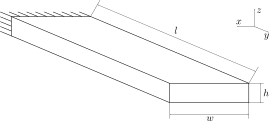

In [187]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '18_BoxBeamGeometry.svg'))

As we can observe in the figure below, adapted from [Taylor & Hunsaker (2021)](https://arc.aiaa.org/doi/abs/10.2514/6.2021-1591), the wingbox of the CRM wing is a much more slender object than the wing itself. Consequently, using a straight box beam with a two-lengths-based aspect ratio equal to the aspect ratio of the CRM wing, $2l/w=9$, does not lead to a structure similar to the CRM wingbox.

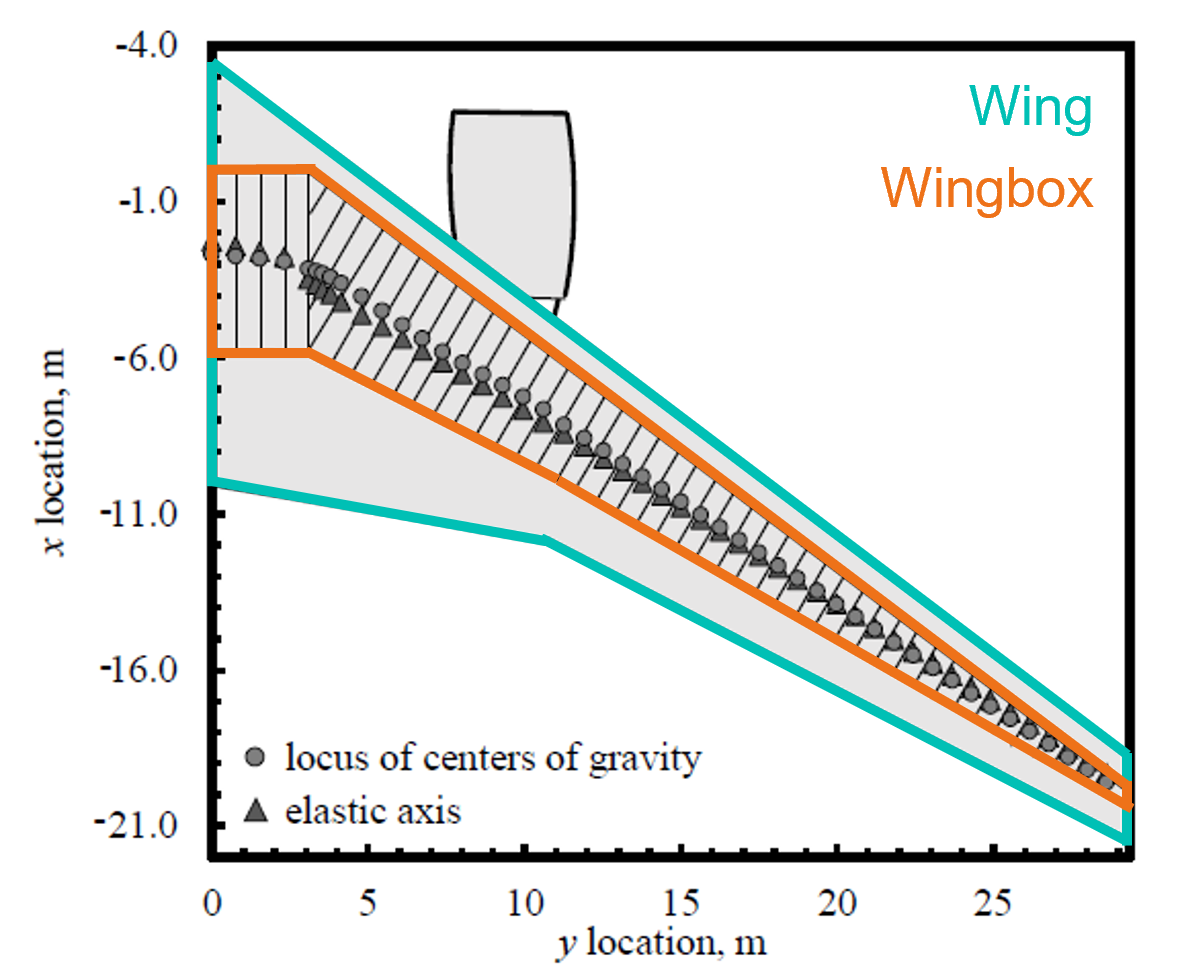

In [188]:
from IPython.display import Image  # class to display images
import os  # module with miscellaneous operating system interfaces

Image(filename=os.path.join('resources', '18_CRM.png'))

For this reason, we want to derive a closer straight box beam approximation of the CRM wingbox. In order to do that, we need to calculate the values of length $l$, width $w$ and height $h$ so that they represent the closest geometric approximation of the CRM wingbox semi-span, width and height, respectively. Of these quantities, only the last two are variable along the span, while the span itself is fixed. As a consequence we can take the lenght of our box beam equal to half the span of the CRM wingbox, $b_{wb}$, which in turn is equal to the wingspan:

$$l=b_{wb}/2.$$

In [189]:
b_wb = 58.76  # [m]
l = b_wb/2  # [m]
print(f'Box beam length: {l:.2f} m')

Box beam length: 29.38 m


Since both the width $w_{wb}(y)$ and the height $h_{wb}(y)$ of the CRM wingbox vary along the span, we need to find a reference value for each to use for our straight box beam model. We can find a reference value of the wingbox width by dividing the wingspan by the wingbox aspect ratio $AR_{wb}$:

$$w=b_{wb}/AR_{wb}.$$

How can we find the the aspect ratio of the CRM wingbox? Similarly to the aspect ratio of a wing, we can define the aspect ratio of the wingbox as the ratio between the square of its span and its planform area $S_{wb}$:

$$AR_{wb}=\frac{\left(b_{wb}\right)^2}{S_{wb}},$$

where we can calculate the latter as the integral of the width along the semi-span:

$$S_{wb}=2\int_0^{b_{wb}/2} w_{wb}(y)\mathrm{d}y.$$

We can infer $w_{wb}(y)$ from the wingbox data reported by [Taylor & Hunsaker (2021)](https://arc.aiaa.org/doi/abs/10.2514/6.2021-1591). Below we codify the spanwise distribution of chord, front and rear spar $x$-coordinate and height of the CRM reported by the authors. In the paper, the spars data is given at each rib station along the span of the wing. These stations include the ribs next to the kink of the wingbox, where some intersect with the last rib aligned with the fuselage, as it can be observed in the figure above. Here, for the purpose of defining our geometry, we remove the rear spar data associated to the ribs that are not connected to the rear spar.

In [190]:
import numpy as np

# Chord distribution along the span
chord = np.array([[0.00, 13.6161],  # xi, chord [m]
                  [0.10, 11.8976],
                  [0.15, 11.0384],
                  [0.20, 10.1790],
                  [0.25, 9.3197],
                  [0.30, 8.4604],
                  [0.35, 7.6010],
                  [0.37, 7.2573],
                  [0.40, 7.0416],
                  [0.45, 6.6821],
                  [0.50, 6.3226],
                  [0.55, 5.9631],
                  [0.60, 5.6035],
                  [0.65, 5.2440],
                  [0.70, 4.8845],
                  [0.75, 4.5250],
                  [0.80, 4.1654],
                  [0.85, 3.8059],
                  [0.90, 3.4464],
                  [0.95, 3.0869],
                  [1.00, 2.7274]])

# Distribution of the front spar nondimensional x-coordinate and height along the span
front_spar = np.array([[0.0000, 0.2524, 2.0371],  # xi, x/c, h [mm]
                       [0.0264, 0.2178, 1.8564],
                       [0.0527, 0.1806, 1.6504],
                       [0.0791, 0.1407, 1.4163],
                       [0.1055, 0.0978, 1.1415],
                       [0.1258, 0.1016, 1.0797],
                       [0.1462, 0.1056, 1.0193],
                       [0.1665, 0.1089, 0.9603],
                       [0.1868, 0.1123, 0.9049],
                       [0.2072, 0.1157, 0.8540],
                       [0.2275, 0.1193, 0.8072],
                       [0.2478, 0.1232, 0.7642],
                       [0.2681, 0.1274, 0.7250],
                       [0.2885, 0.1319, 0.6893],
                       [0.3088, 0.1369, 0.6568],
                       [0.3291, 0.1422, 0.6273],
                       [0.3495, 0.1481, 0.6009],
                       [0.3698, 0.1545, 0.5777],
                       [0.3901, 0.1570, 0.5639],
                       [0.4104, 0.1596, 0.5514],
                       [0.4308, 0.1579, 0.5398],
                       [0.4511, 0.1650, 0.5287],
                       [0.4714, 0.1680, 0.5174],
                       [0.4918, 0.1710, 0.5064],
                       [0.5121, 0.1742, 0.4967],
                       [0.5324, 0.1775, 0.4880],
                       [0.5528, 0.1810, 0.4797],
                       [0.5731, 0.1847, 0.4715],
                       [0.5934, 0.1886, 0.4634],
                       [0.6137, 0.1927, 0.4553],
                       [0.6341, 0.1970, 0.4472],
                       [0.6544, 0.2015, 0.4385],
                       [0.6747, 0.2063, 0.4291],
                       [0.6951, 0.2114, 0.4194],
                       [0.7154, 0.2168, 0.4098],
                       [0.7357, 0.2226, 0.4002],
                       [0.7560, 0.2287, 0.3904],
                       [0.7764, 0.2353, 0.3805],
                       [0.7967, 0.2423, 0.3703],
                       [0.8170, 0.2498, 0.3599],
                       [0.8374, 0.2579, 0.3492],
                       [0.8577, 0.2666, 0.3382],
                       [0.8780, 0.2760, 0.3269],
                       [0.8984, 0.2862, 0.3154],
                       [0.9187, 0.2973, 0.3038],
                       [0.9390, 0.3094, 0.2922],
                       [0.9593, 0.3209, 0.2808],
                       [0.9797, 0.3373, 0.2691],
                       [1.0000, 0.3536, 0.2560]])

# Distribution of the rear spar nondimensional x-coordinate and height along the span
rear_spar = np.array([[0.0000, 0.6936, 1.2970],  # xi, x_te/c, h_te [mm]
                      [0.0264, 0.6730, 1.2942],
                      [0.0527, 0.6509, 1.2858],
                      [0.0791, 0.6272, 1.2711],
                      [0.1055, 0.6019, 1.2473],
                      [0.1084, 0.6026, 1.2320],
                      [0.1310, 0.6090, 1.1220],
                      [0.1535, 0.6157, 1.0316],
                      [0.1760, 0.6219, 0.9573],
                      [0.1986, 0.6286, 0.8916],
                      [0.2211, 0.6356, 0.8320],
                      [0.2436, 0.6432, 0.7777],
                      [0.2662, 0.6515, 0.7271],
                      [0.2887, 0.6607, 0.6788],
                      [0.3112, 0.6707, 0.6310],
                      [0.3338, 0.6818, 0.5817],
                      [0.3563, 0.6941, 0.5303],
                      [0.3786, 0.7016, 0.4903],
                      [0.4004, 0.7002, 0.4761],
                      [0.4223, 0.6988, 0.4635],
                      [0.4441, 0.6972, 0.4514],
                      [0.4660, 0.6957, 0.4400],
                      [0.4878, 0.6941, 0.4284],
                      [0.5096, 0.6924, 0.4171],
                      [0.5315, 0.6906, 0.4065],
                      [0.5533, 0.6888, 0.3964],
                      [0.5752, 0.6868, 0.3860],
                      [0.5970, 0.6848, 0.3755],
                      [0.6189, 0.6826, 0.3653],
                      [0.6407, 0.6804, 0.3555],
                      [0.6626, 0.6779, 0.3460],
                      [0.6844, 0.6754, 0.3370],
                      [0.7063, 0.6726, 0.3284],
                      [0.7281, 0.6697, 0.3199],
                      [0.7500, 0.6666, 0.3109],
                      [0.7718, 0.6633, 0.3005],
                      [0.7936, 0.6597, 0.2894],
                      [0.8155, 0.6558, 0.2786],
                      [0.8373, 0.6516, 0.2682],
                      [0.8592, 0.6470, 0.2583],
                      [0.8810, 0.6420, 0.2487],
                      [0.9029, 0.6365, 0.2386],
                      [0.9247, 0.6303, 0.2276],
                      [0.9466, 0.6236, 0.2167],
                      [0.9684, 0.6163, 0.2062],
                      [1.0000, 0.6039, 0.1890]])

Considering how the distribution of the $x$-coordinates of the front and rear spars is provided, we can interpolate the coordinates to a common set of spanwise stations and calculate the wingbox width $w_{wb}(y)$ as the difference between the rear and front spar coordinates, $x_{rear}(y)-x_{front}(y)$.

Let's calculate $S_{wb}$, $AR_{wb}$ and $w$ and print the results.

In [191]:
x_front = front_spar[:, 1] * np.interp(front_spar[:, 0], chord[:, 0], chord[:, 1])  # calculate x-coordinate of front spar --> x/c(y)*c(y) - chord values are interpolated to the spanwise station of the spar
x_rear = rear_spar[:, 1] * np.interp(rear_spar[:, 0], chord[:, 0], chord[:, 1])  # calculate x-coordinate of rear spar
xi = np.unique(np.concatenate([front_spar[:, 0], rear_spar[:, 0]]))  # combine spanwise stations of front and rear spar
w_wb = np.interp(xi, rear_spar[:, 0], x_rear) - np.interp(xi, front_spar[:, 0], x_front)  # calculate wingbox width at the combined spanwise stations
S_wb = 2*(np.trapz(w_wb, xi*b_wb/2))  # calculate the wingbox planform area
AR_wb = b_wb**2/S_wb  # calculate the wingbox aspect ratio
w = b_wb/AR_wb  # calculate the wingbox reference width
print(f'Wingbox planform area: {S_wb:.0f} m\u00b2\nWingbox aspect ratio: {AR_wb:.1f}\nEquivalent box beam width: {w:.2f} m')

Wingbox planform area: 200 m²
Wingbox aspect ratio: 17.2
Equivalent box beam width: 3.41 m


With the length and the width of our new box beam, we can also calculate its length-based aspect ratio, $l/w$, and compare it with the value of our previous box beam.

In [192]:
AR = l/w
print(f'Box beam aspect ratio: {AR:.1f}')

Box beam aspect ratio: 8.6


We have found a value that is almost double than the one of our previous box beam (4.5)! This gives us a feeling of how the CRM wingbox is a much more slender structure than the one we have been using so far.

What about the equivalent box beam height? The idea here is that we can obtain a reference height of the CRM wingbox by dividing the wingbox volume $V_{wb}$ by the planform area:

$$h=\frac{V_{wb}}{S_{wb}}.$$

And how can we calculate the volume of the wingbox? Well, we can think of it as the integral of the cross-sectional area of the wingbox along the semi-span. In turn, the cross-sectional area at each spanwise station can be approximated with the area of the trapezium formed by connecting the two spars:

$$V_{wb}=2\int_0^{b_{wb}/2}\frac{h_{front}(y)+h_{rear}(y)}{2}w_{wb}(y)\mathrm{d}y,$$

where $h_{front}(y)$ and $h_{rear}(y)$ are the spanwise distribution of the front and rear spar height, respectively.

In [193]:

h_front = np.interp(xi, front_spar[:, 0], front_spar[:, 2])  # interpolate front spar height to the combined spanwise stations
h_rear = np.interp(xi, rear_spar[:, 0], rear_spar[:, 2])  # interpolate rear spar height to the combined spanwise stations
cross_sectional_area = (h_front+h_rear)/2*w_wb
V_wb = 2*(np.trapz(cross_sectional_area, xi*b_wb/2))
h = V_wb/S_wb
print(f'Wingbox volume: {V_wb:.0f} m\u00b3\nEquivalent box beam height: {h:.2f} m')

Wingbox volume: 154 m³
Equivalent box beam height: 0.77 m


We can also calculate the nondimensional height $h/w$ of our new box beam and compare it with the old one.

In [194]:
nondimensional_height = h/w
print(f'Nondimensional height: {nondimensional_height:.2f}')

Nondimensional height: 0.23


This value is actually not that far from the one of our previous box beam, meaning that the cross-sectional properties are not going to be much different.

## Setup of the numerical model <a name="numerical-model"></a>

***

Having found the length, width and height of our new box beam, we now need to define the wall thickness and the internal reinforcements. We first convert the found parameters from meters to millimiters and then set the wall thickness to $1/100$ of the height in order to obtain a thin-walled structure. We are going to use the same thickness for all elements of the structure.

In [195]:
l = l*1e3  # [mm]
w = w*1e3  # [mm]
h = h*1e3  # [mm]
non_dimensional_thickness = 1/100  # t/h
t = h*non_dimensional_thickness  # wall thickness [mm]
print(f'Wall thickness: {t:.1f} mm')

Wall thickness: 7.7 mm


The prescribed value of wall thickness is in the lower range of the skin thicknesses obtained by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the uCRM-9.

Next we define the internal structure. Since we want to keep the model simple, we are going to use only two stiffeners for each skin, similarly to our [old box beam](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb). The idea here is to have a structure that retains the essential features of a wingbox in terms of buckling behavior, and we consider this approach satisfactory. We define the $x$-coordinates of the stiffeners based on their prescribed number and then we set their height equal to $1/10$ of the box beam height.

In [196]:
# Find stiffeners location based on prescribed number of stiffeners
no_stiffeners = 2
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]

# Define stiffeners height
stiffeners_height = h/10

# Print info
np.set_printoptions(precision=2)
print('Stiffeners x-coordinate [m]:')
print(stiffeners_x_locations/1e3)
print(f'Stiffeners height: {stiffeners_height:.0f} mm')

Stiffeners x-coordinate [m]:
[1.14 2.27]
Stiffeners height: 77 mm


We note that the prescribed value of stiffeners height is sligthly above the range obtained by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the uCRM. However, this should not be of great importance, as in our case there is a substantial difference both in the arrangement of the reinforcements and in the analsysis method.

As far as the ribs are concerned, we use a similar approach to our [old box beam](12_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs_and_Stiffeners.ipynb) to define their spacing. Considering the [analytical results for a thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb#problem-definition) as a first order approximation, we multiply the stiffeners spacing by $1.4$, with the aim of having the buckling load of the rib-stiffener bay approximately the highest possible for a buckling mode with a single wave. Then, we define the number of ribs and their $y$-coordinates based on the prescribed spacing.

 We recall that this is not a correct approach, as the internal bays of a reinforced plate behave differently from a simply supported plate of the same dimensions. However, we only want to obtain a vaguely reasonable value of stiffeners spacing, so we don't need to use a very accurate approach.

In [197]:
# Find ribs location based on prescribed spacing
stiffeners_spacing = w/(no_stiffeners + 1)
ribs_spacing = stiffeners_spacing*1.4
no_ribs = round(l/ribs_spacing) + 1
ribs_y_locations = np.linspace(0, l, no_ribs)

# Print info
print(f"Number of ribs: {no_ribs:d}")
print('Ribs y-coordinate [m]:')
print(ribs_y_locations/1e3)

Number of ribs: 19
Ribs y-coordinate [m]:
[ 0.    1.63  3.26  4.9   6.53  8.16  9.79 11.43 13.06 14.69 16.32 17.95
 19.59 21.22 22.85 24.48 26.12 27.75 29.38]


The last step before creating the mesh is to define the material properties of the structure. We use the same properties of our previous notebooks.

In [198]:
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

Now we want to create an example mesh to show how our new box beam looks like. We select an element length equal to half the height of the box beam and we call the function `mesh_stiffened_box_beam_with_pyvista` from the `box_beam_utils` module to generate the mesh. This returns a `PolyData` object which represents the mesh, and we can plot it using the `plot` method.

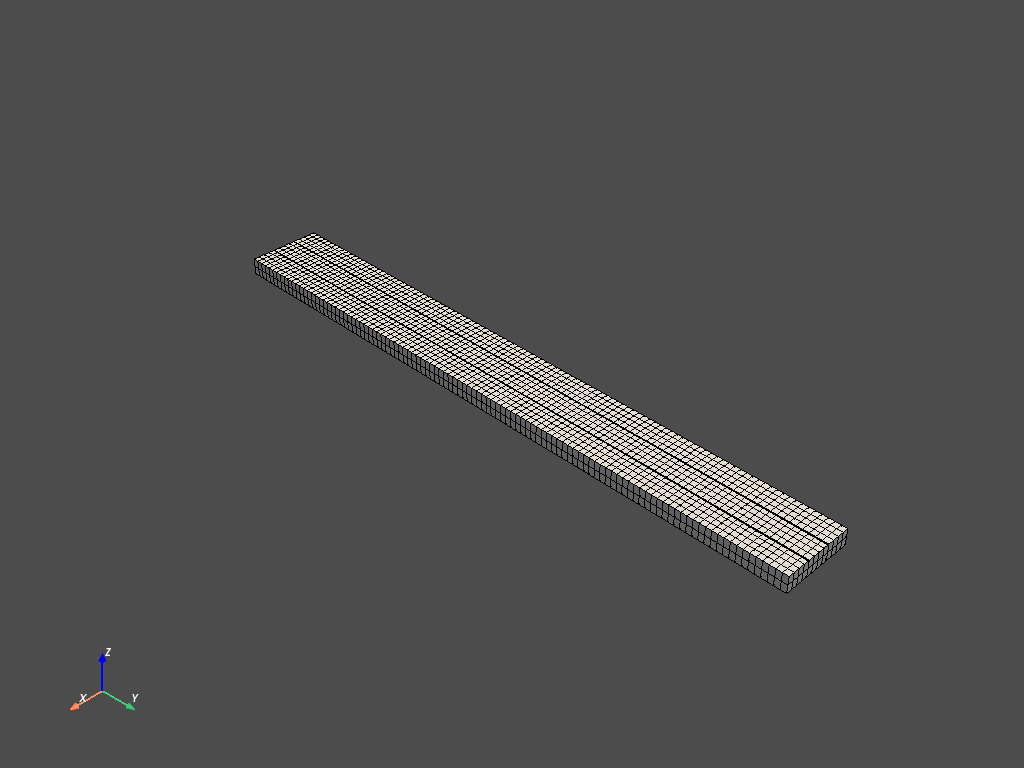

In [199]:
from resources import box_beam_utils

element_length = h/2  # [mm]
example_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                   stiffeners_x_coordinates=stiffeners_x_locations,
                                                                   stiffeners_height=stiffeners_height, element_length=element_length)
example_mesh.plot(show_edges=True, jupyter_backend='static')

Successively, we need to create a base bdf input, that we are going to complete each time depending on the analysis we want to perform. For this purpose we use the function `create_base_bdf_input` from the `box_beam_utils` module. Let's find the nodes' coordinates and the connectivity matrix from the example mesh created earlier, create the base bdf input and print a summary of its Nastran cards with the `get_bdf_stats` method.

In [200]:
nodes_xyz_array = example_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = example_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
example_bdf_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                         nodes_xyz_array=nodes_xyz_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(example_bdf_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 4133

bdf.elements: 0
  CQUAD4   : 4344

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Finally, it's time to define our load. Analogously to our previous notebooks, we are going to consider a concentrated bending load applied at the tip, as shown below. We define the function `apply_tip_concentrated_load` that performs the following steps:

- adds a master node at the center of the tip section;
- connects the master node to the nodes on the edge of the tip rib with a RBE3 element, which defines the motion at a reference grid point as the weighted average of the motions at a set of other grid points;
- applies a unitary vertical force at the master point with a FORCE card.

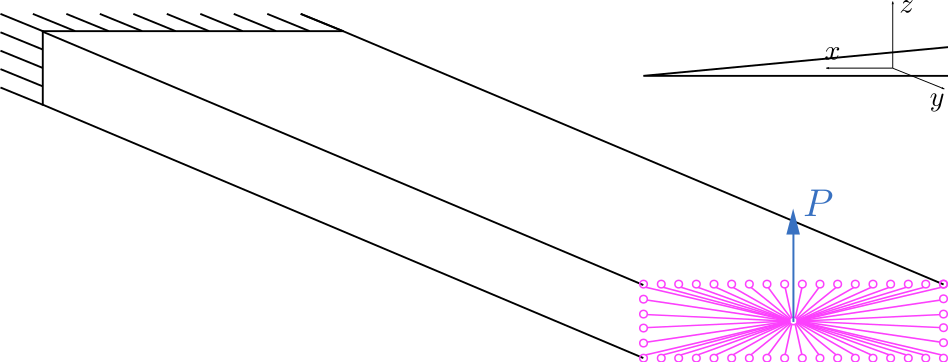

In [201]:
SVG(filename=os.path.join('resources', '08_BoxBeamConcentratedLoad.svg'))

In [202]:
from resources import pynastran_utils

def apply_tip_concentrated_load(bdf_input, force_id):
    # Add master node at the center of the tip section
    master_node_id = len(bdf_input.nodes) + 1
    bdf_input.add_grid(master_node_id, [w/2, l, 0.])
    # Find id of the nodes on the edge of the tip rib
    tolerance = t/10  # we define a geometric tolerance to find the nodes on the edge of the tip rib equal to 1/10 of the cross-sectional thickness
    tip_edge_nodes_ids = [nid for nid in bdf_input.nodes if (np.abs(bdf_input.nodes[nid].xyz[1] - l) < tolerance) &
                          (np.abs((bdf_input.nodes[nid].xyz[0]) < tolerance) | (np.abs(bdf_input.nodes[nid].xyz[0] - w) < tolerance) |
                          (np.abs(bdf_input.nodes[nid].xyz[2] - h/2) < tolerance) | (np.abs(bdf_input.nodes[nid].xyz[2] + h/2) < tolerance))]
    # Add RBE3 to connect master node with edge nodes of tip rib
    rbe3_eid = len(bdf_input.elements) + 1
    bdf_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_edge_nodes_ids),
                       comps=['123456']*len(tip_edge_nodes_ids), Gijs=tip_edge_nodes_ids)
    # Add concentrated force
    force_direction = [0., 0., 1.]
    pynastran_utils.add_unitary_force(bdf_object=bdf_input, nodes_ids=[master_node_id], set_id=force_id, direction_vector=force_direction)
    # Return id of master node
    return master_node_id

Now we have all the ingredients to move on to the analysis of our new box beam model.

## Mesh convergence study <a name="mesh-convergence"></a>

***

Analogously to what we did for our old box beam models, we need perform a mesh convergence study to establish an appropriate mesh size for our analyses. For this reason, we define 10 different linear sizes for the shell elements, evenly spaced on a log scale between the height of the box beam and four times the thickness of the shell elements. For each shell element size, we generate a mesh, create the base `BDF` ojbect, apply the load, and run SOL 105 by calling the function `run_sol_105_buckling_analysis` from the `pynastran_utils` module. For each analysis we store the number of degrees of freedom of the model and the calculated critical buckling load to monitor how the latter changes with the former.

In [203]:
%matplotlib widget

import matplotlib.pyplot as plt  # plotting library
import os

plt.rcParams["figure.dpi"] = 120  # set default dpi of figures
force_set_id = 11  # define FORCE card identification number
eigenvalue_calculation_subcase_id = 2  # define subcase id of eigenvalue calculation

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
shell_element_lengths = np.geomspace(h/2, stiffeners_height/8, 10) # [m]
# shell_element_lengths = [shell_element_lengths[2]]
print("Prescribed length of shell elements for mesh convergence study [mm]:")
print(shell_element_lengths)

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(shell_element_lengths), dtype=int)
dofs = np.empty(np.shape(shell_element_lengths))
linear_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Define name of analysis directory and of input file
analysis_directory_name = "18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model"
analysis_directory_path = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 70  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(0, .14))  # move colorbar upwards

# Iterate through the different edge lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate base bdf input
    box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                        stiffeners_x_coordinates=stiffeners_x_locations,
                                                                        stiffeners_height=stiffeners_height, element_length=element_length)
    nodes_xyz_array = box_beam_mesh.points
    nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t,
                                                               nodes_xyz_array=nodes_xyz_array,
                                                               nodes_connectivity_matrix=nodes_connectivity_matrix)
    # Apply concetrated load at the tip
    apply_tip_concentrated_load(linear_buckling_bdf, force_set_id)
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(linear_buckling_bdf.elements)
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    # Run SOL 105 and return OP2 object
    input_name = f"linear_buckling_{no_elements[count]}_elements"
    sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=linear_buckling_bdf, static_load_set_id=force_set_id,
                                                                analysis_directory_path=analysis_directory_path, input_name=input_name,
                                                                run_flag=False)
    # Find critical buckling load and print it
    print(f"\n\033[1mResults of model with:\n- {element_length:.0f} mm prescribed element length\n- {no_elements[count]:.0f} elements\033[0m\n", 
          f"\033[1m- {dofs[count]:.0f} degrees of freedom\033[0m")
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
    print(f"Buckling load: {linear_buckling_loads[count]:.0f} N")
    # Plot critical buckling mode
    # print("Buckling mode:")
    # _, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component='tz', colormap='coolwarm',
    #                                                  length_unit='m', displacement_amplification_factor=2, unit_scale_factor=1e-3)
    # adjust_3d_plot(ax, cbar)
    # plt.show()

Prescribed length of shell elements for mesh convergence study [mm]:
[384.25 255.04 169.28 112.36  74.57  49.5   32.85  21.81  14.47   9.61]


subcase=0 already exists...skipping


Nastran job linear_buckling_4344_elements.bdf completed
Wall time: 2.0 s



Results of model with:
- 384 mm prescribed element length
- 4344 elements
 - 24522 degrees of freedom
Buckling load: 13255 N


subcase=0 already exists...skipping


Nastran job linear_buckling_8856_elements.bdf completed
Wall time: 4.0 s



Results of model with:
- 255 mm prescribed element length
- 8856 elements
 - 50442 degrees of freedom
Buckling load: 12604 N


subcase=0 already exists...skipping


Nastran job linear_buckling_14976_elements.bdf completed
Wall time: 9.0 s



Results of model with:
- 169 mm prescribed element length
- 14976 elements
 - 85866 degrees of freedom
Buckling load: 12419 N


subcase=0 already exists...skipping


Nastran job linear_buckling_33120_elements.bdf completed
Wall time: 21.0 s



Results of model with:
- 112 mm prescribed element length
- 33120 elements
 - 192354 degrees of freedom
Buckling load: 12318 N


subcase=0 already exists...skipping


Nastran job linear_buckling_61632_elements.bdf completed
Wall time: 37.0 s



Results of model with:
- 75 mm prescribed element length
- 61632 elements
 - 359970 degrees of freedom
Buckling load: 12307 N


subcase=0 already exists...skipping


Nastran job linear_buckling_134496_elements.bdf completed
Wall time: 102.0 s



Results of model with:
- 49 mm prescribed element length
- 134496 elements
 - 790674 degrees of freedom
Buckling load: 12309 N


subcase=0 already exists...skipping


Nastran job linear_buckling_301248_elements.bdf completed
Wall time: 534.0 s



Results of model with:
- 33 mm prescribed element length
- 301248 elements
 - 1777794 degrees of freedom
Buckling load: 12305 N


subcase=0 already exists...skipping


Nastran job linear_buckling_674424_elements.bdf completed
Wall time: 1811.0 s



Results of model with:
- 22 mm prescribed element length
- 674424 elements
 - 3990282 degrees of freedom
Buckling load: 12311 N


subcase=0 already exists...skipping


Nastran job linear_buckling_1502064_elements.bdf completed
Wall time: 9876.0 s



Results of model with:
- 14 mm prescribed element length
- 1502064 elements
 - 8902986 degrees of freedom
Buckling load: 12311 N


subcase=0 already exists...skipping


Nastran job linear_buckling_3337920_elements.bdf completed
Wall time: 16681.0 s



Results of model with:
- 10 mm prescribed element length
- 3337920 elements
 - 19803858 degrees of freedom
Buckling load: 12322 N


Let's plot the critical buckling load against the number of degrees of freedom. We also calculate the percentage difference of each buckling load w.r.t. the one of the finest mesh and visualize it on the right axis.

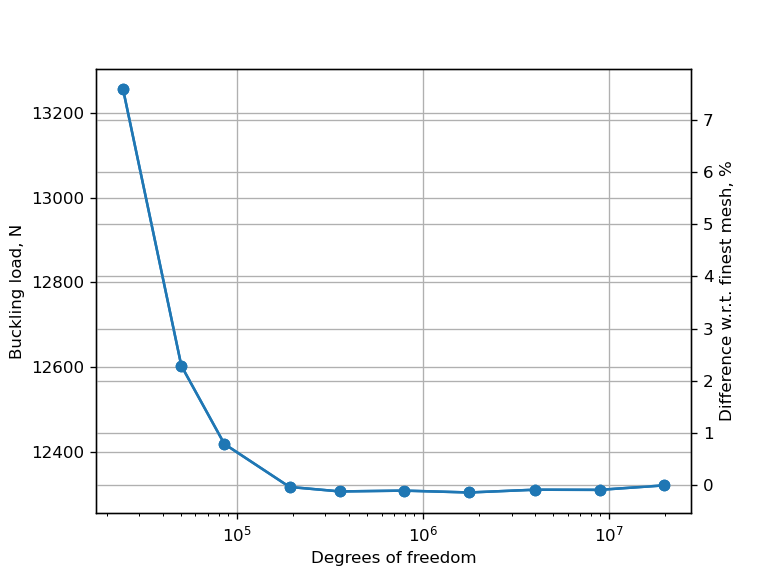

In [204]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load, N') #, color=buckling_load_line[0].get_color())
ax2.set_ylabel('Difference w.r.t. finest mesh, %') #, color=percentage_diff_line[0].get_color())
ax1.grid(True)
ax2.grid(True)
plt.show()


We define the mesh to be converged when the difference with respect to the finest mesh is below 1%.

In [230]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0]  # find index corresponding to first percentage difference below 1
element_length_converged_mesh = shell_element_lengths[converged_mesh_index]  # store shell length of converged mesh
no_elements_converged_mesh = no_elements[converged_mesh_index]  # store number of elements of converged mesh
sol_105_buckling_load = linear_buckling_loads[converged_mesh_index]  # store buckling load of converged mesh
print(f"The mesh is converged for a target shell element length of {element_length_converged_mesh:.0f} mm, ",
      f"corresponidng to {no_elements_converged_mesh} elements, ",
      f"{dofs[converged_mesh_index]:.0f} degrees of freedom and to a linear buckling load of {sol_105_buckling_load:.0f} N.")

The mesh is converged for a target shell element length of 169 mm,  corresponidng to 14976 elements,  85866 degrees of freedom and to a linear buckling load of 12419 N.


## Nonlinear analysis: mesh convergence verification <a name="mesh-verification"></a>

***

For our mesh convergence study we performed linear buckling analyses using Nastran's SOL 105. However, a slender structure like our new box beam may be highly nonlinear and consequently the mesh obtained from the convergence study may result inadequate. For this reason we want to verify the mesh convergence in the nonlinear regime.

We are going to do this by comparing the tip and the local displacement resulting from a nonlinear analysis with two different meshes: one obtained with the prescribed element length of the converged mesh and the other obtained with half of such length. To evaluate the local displacement of the two different models we are going to select the node where SOL 105 predits the largest displacement in the critical buckling mode and we'll consider its main displacement component. Looking at the buckling shapes of the mesh convergence study, the node will correspond to the one at the center of the first rib-stiffener bay and the main component will be the one along the $z$-axis.

We create our first bdf input using the prescribed element length of the converged mesh. Then we set up SOL 106 with the arc-length method using the usual parameters for a fine step size.

In [231]:
# Create mesh with converged target element length
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations,
                                                                    stiffeners_height=stiffeners_height,
                                                                    element_length=element_length_converged_mesh)

# Create BDF obejct and apply concentrated load at the tip
box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_mesh.points, box_beam_mesh.faces.reshape(-1, 5)[:, 1:])
tip_master_node_id = apply_tip_concentrated_load(box_beam_bdf, force_set_id)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
fine_nlparm_id = 1  # id of NLPARM card with fine arc-length method parameters
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, nlparm_id=fine_nlparm_id, eps_p=1e-3, eps_w=1e-7, ninc=100, max_bisect=10,
                                         minalr=.01, maxalr=1.0001, desiter=5, maxinc=2000)

subcase=0 already exists...skipping


To get a nonlinear response from the structure, we apply twice the buckling load predicted by SOL 105.

In [232]:
load_set_id = force_set_id + 1  # id of load set
scale_factor = sol_105_buckling_load*2  # scale factor to apply to the load set
box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])  # add LOAD card
loading_subcase_id = 1  # id of first subcase
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=1, load_set_id=load_set_id)  # create subcase with static load

Now we run our nonlinear analysis and we read the tip displacement from the op2 file, which corresponds to the $z$-displacement of the master node at the tip.

In [233]:
# Run analysis
method_set_id = load_set_id + 1
no_eigenvalues = 20
input_name_reference_mesh = f"nonlinear_analysis_{no_elements_converged_mesh}_elements"
sol_106_op2_reference_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name_reference_mesh, run_flag=False)

# Read tip displacement from op2 file
component_index = 2  # index of z component of displacement
reference_tip_displacement = sol_106_op2_reference_mesh.displacements[loading_subcase_id].data[-1, tip_master_node_id - 1, component_index]  # read z displacement of subcase 1, last converged iteration

Nastran job nonlinear_analysis_14976_elements.bdf completed
Wall time: 11224.0 s


To find the node associated to the local displacement, we need to find the node where SOL 105 predicts the largest displacement in the critical buckling mode. Consequently, we read the op2 file corresponding to the linear buckling analysis performed during the mesh convergence study and we look for the node where the first eigenvector has the largest displacement.

In [234]:
from pyNastran.op2.op2 import read_op2

# Read op2 file of linear buckling analysis
input_name = f"linear_buckling_{no_elements_converged_mesh}_elements"
sol_105_op2_filepath = os.path.join(analysis_directory_path, input_name + ".op2")
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[max_displacement_index, 0]

We can then visualize the buckling mode and the location of the selected node.

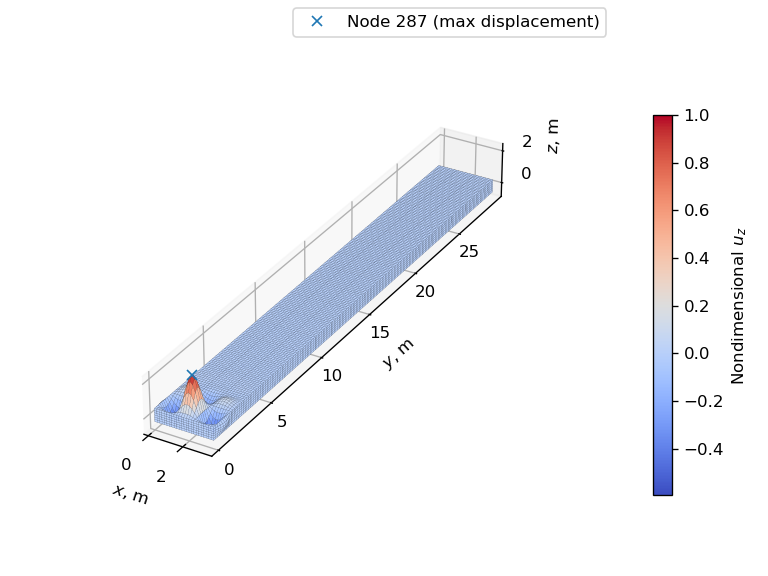

In [235]:
# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component="tz", colormap="coolwarm",
                                                 length_unit="m", displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], "x",
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

And finally we can read the local displacement from the op2 file, which corresponds to the $z$-displacement of the selected node.

In [236]:
reference_local_displacement = sol_106_op2_reference_mesh.displacements[loading_subcase_id].data[-1, max_displacement_index, component_index]  # read z displacement of subcase 1, last converged iteration

Now we create the model with a refined mesh, where we prescribe half of element length used for the reference model.

In [237]:
# Create mesh with half of the converged target element length
box_beam_refined_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                            stiffeners_x_coordinates=stiffeners_x_locations,
                                                                            stiffeners_height=stiffeners_height,
                                                                            element_length=element_length_converged_mesh/2)

# Create BDF object and apply concentrated load at the tip
refined_mesh_box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t, box_beam_refined_mesh.points, box_beam_refined_mesh.faces.reshape(-1, 5)[:, 1:])
refined_mesh_tip_master_node_id = apply_tip_concentrated_load(refined_mesh_box_beam_bdf, force_set_id)

subcase=0 already exists...skipping


We first run a linear buckling analysis with SOL 105, in order to find the node where the critical buckling mode has the largest displacement. Then we plot together the critical buckling mode and the node that we've found.

Nastran job linear_buckling_48300_elements.bdf completed
Wall time: 32.0 s


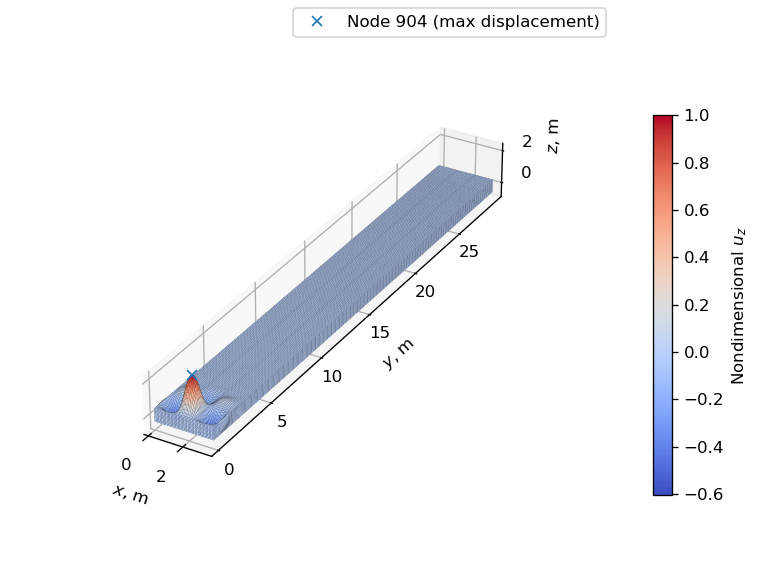

In [238]:
# Run SOL 105 and return OP2 object
no_elements_refined_mesh = len(refined_mesh_box_beam_bdf.elements)
input_name = f"linear_buckling_{no_elements_refined_mesh}_elements"
sol_105_op2_refined_mesh = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=refined_mesh_box_beam_bdf.__deepcopy__({}), static_load_set_id=force_set_id,
                                                                         analysis_directory_path=analysis_directory_path, input_name=input_name,
                                                                         run_flag=False)

# Find node where max displacement occurs
refined_mesh_max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2_refined_mesh.eigenvectors[eigenvalue_calculation_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
refined_mesh_max_displacement_node_id = sol_105_op2_refined_mesh.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[refined_mesh_max_displacement_index, 0]

# Plot buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2_refined_mesh, subcase_id=eigenvalue_calculation_subcase_id, displacement_component="tz",
                                                 colormap="coolwarm", length_unit="m", displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
refined_mesh_max_displacement_node_xyz = sol_105_op2_refined_mesh.nodes[refined_mesh_max_displacement_node_id].xyz*1e-3 + sol_105_op2_refined_mesh.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, refined_mesh_max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(refined_mesh_max_displacement_node_xyz[0], refined_mesh_max_displacement_node_xyz[1], refined_mesh_max_displacement_node_xyz[2], "x",
        label=f"Node {refined_mesh_max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

Now we can define the subcase for the nonlinear analysis and set up SOL 106 with the arc-length method using the usual parameters for a fine step size. We apply the same load as for the reference model and we run the analysis.

In [239]:
# Create static load subcase with twice the buckling load predicted by SOL 105
refined_mesh_box_beam_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
pynastran_utils.create_static_load_subcase(bdf_object=refined_mesh_box_beam_bdf, subcase_id=loading_subcase_id, load_set_id=load_set_id)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
pynastran_utils.set_up_arc_length_method(bdf_object=refined_mesh_box_beam_bdf, eps_p=1e-3, eps_w=1e-7, ninc=100, max_bisect=10,
                                         minalr=.01, maxalr=1.0001, desiter=5, maxinc=2000)

# Run analysis
input_name_refined_mesh = f"nonlinear_analysis_{no_elements_refined_mesh}_elements"
sol_106_op2_refined_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=refined_mesh_box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name_refined_mesh, run_flag=False)

Nastran job nonlinear_analysis_48300_elements.bdf completed
Wall time: 50914.0 s


Also in this case we read the local and tip displacement from the op2 file.

In [240]:
sol_106_op2_filepath_refined_mesh = os.path.join(analysis_directory_path, input_name_refined_mesh + ".op2")  # path of op2 file
sol_106_op2_refined_mesh = read_op2(op2_filename=sol_106_op2_filepath_refined_mesh, debug=None, load_geometry=True)  # read op2 file
refined_mesh_local_displacement = sol_106_op2_refined_mesh.displacements[loading_subcase_id].data[-1, refined_mesh_max_displacement_index, component_index]  # read z displacement of local node in subcase 1, last converged iteration
refined_mesh_tip_displacement = sol_106_op2_refined_mesh.displacements[loading_subcase_id].data[-1, refined_mesh_tip_master_node_id - 1, component_index]  # read z displacement of tip node in subcase 1, last converged iteration

Finally, we can calculate the percentage difference of the displacements obtained with the refined mesh w.r.t. the displacements obtained with the reference mesh.

In [241]:
print(f"Percentage difference of tip displacement: {(refined_mesh_tip_displacement/reference_tip_displacement - 1)*100:.1f} %")
print(f"Percentage difference of local displacement: {(refined_mesh_local_displacement/reference_local_displacement - 1)*100:.1f} %")

Percentage difference of tip displacement: 1.0 %
Percentage difference of local displacement: -3.4 %


The difference for both displacements is smaller than 5%, so we consider the mesh selected with the convergence study to be adequate for the kind of nonlinear analyses that we are going to carry out in the remainder of the notebook. However, the final value of local and tip displacements give only a partial picture of the accuracy of the mesh. In fact, in our nonlinear analyses the equilibrium path followed by the structure to achieve its final deformantion is even more important. For this reason, we will now compare the equilibrium paths followed by the two models during the analyses that we've just performed.

To do this, we plot the equilibrium paths in a 3D equilibrium diagram, where we use the $x$-axis to represent the local displacements, the $y$-axis to represent the tip displacements and the $z$-axis to represent the applied load. Consequently, we read the history of these quantities from the op2 files using the function `read_load_displacement_history` from the `pynastran_utils` module. We then nondimensionalize the local displacemnts with the width of the box beam, the tip displacements with the length of the box beam and the applied load with the buckling load predicted by SOL 105.

In [242]:
# Read tip and local displacements of the reference mesh
local_displacements = {}
tip_displacements = {}
applied_loads = {}
_, _, local_displacements["reference mesh"] = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_reference_mesh,
                                                                                                      displacement_node_id=max_displacement_node_id)
_, applied_loads["reference mesh"], tip_displacements["reference mesh"] = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_reference_mesh,
                                                                                                                                  displacement_node_id=tip_master_node_id)

# Read tip and local displacements of the refined mesh
_, _, local_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_refined_mesh,
                                                                                                    displacement_node_id=refined_mesh_max_displacement_node_id)
_, applied_loads["refined mesh"], tip_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_refined_mesh,
                                                                                                                              displacement_node_id=refined_mesh_tip_master_node_id)
    
# Create dictionaries with nondimensional tip displacements and applied loads
nondimensional_local_displacements = {key: local_displacements[key][loading_subcase_id][:, component_index]/w
                                      for key in local_displacements}
nondimensional_tip_displacements = {key: tip_displacements[key][loading_subcase_id][:, component_index]/l
                                    for key in tip_displacements}
nondimensional_applied_loads = {key: applied_loads[key][loading_subcase_id][:, component_index]/sol_105_buckling_load
                                for key in applied_loads}

Finally, we plot together the equilibrium paths of the two models.

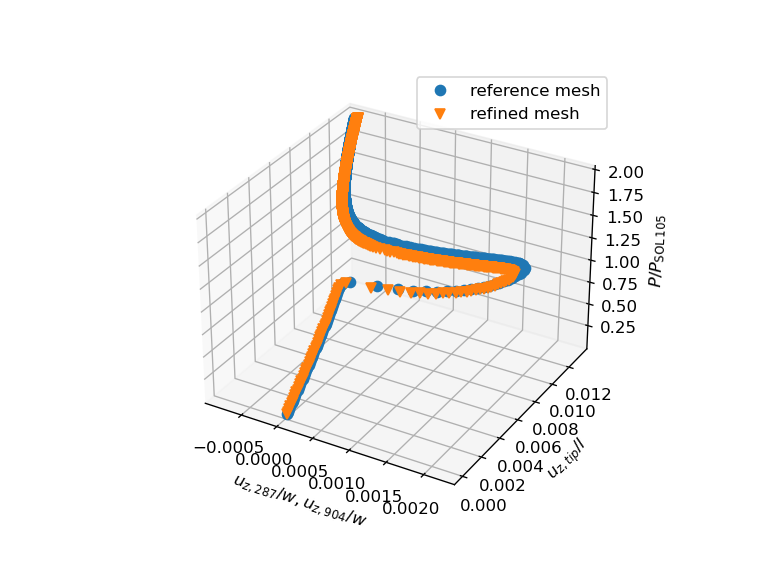

In [243]:
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

markers = list(Line2D.markers.keys())[2:]  # list of marker characters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors

# Create 3D plot of equilibrium diagram
plt.figure()
ax_3d = plt.axes(projection="3d")
for count, key in enumerate(nondimensional_local_displacements):
    ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key], nondimensional_applied_loads[key],
                 markers[count], color=colors[count], label=key)

# Set plot appearance
ax_3d.set_xlabel(f"$u_{{z, {max_displacement_node_id:d}}}/w, u_{{z, {refined_mesh_max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z, tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
ax_3d.legend()
plt.show()

The two equilibrium paths are very close to each other, suggesting that the reference mesh is adequate for our nonlinear analyses. However, they appear to have a surprising shape, something that we had not seen in our previous notebooks! In fact, if for the first segment of the paths we can observe a broken-bifurcation-like response, similar to the one of our previous box beam models, at some point the applied load along the path starts decreasing and the local displacement appears to change sign. The applied load then increases again with a negative local displacement. This behavior corresponds to a limit point, where the structure is supposed to become unstable and to undergo a snap-through when loaded in real life.

It is the first time that we observe such a behavior along the natural path of a box beam model. To verify the stability of the structure along the followed paths, we are going plot the eigenvalues of the tangent stiffness matrix along against the applied loads.

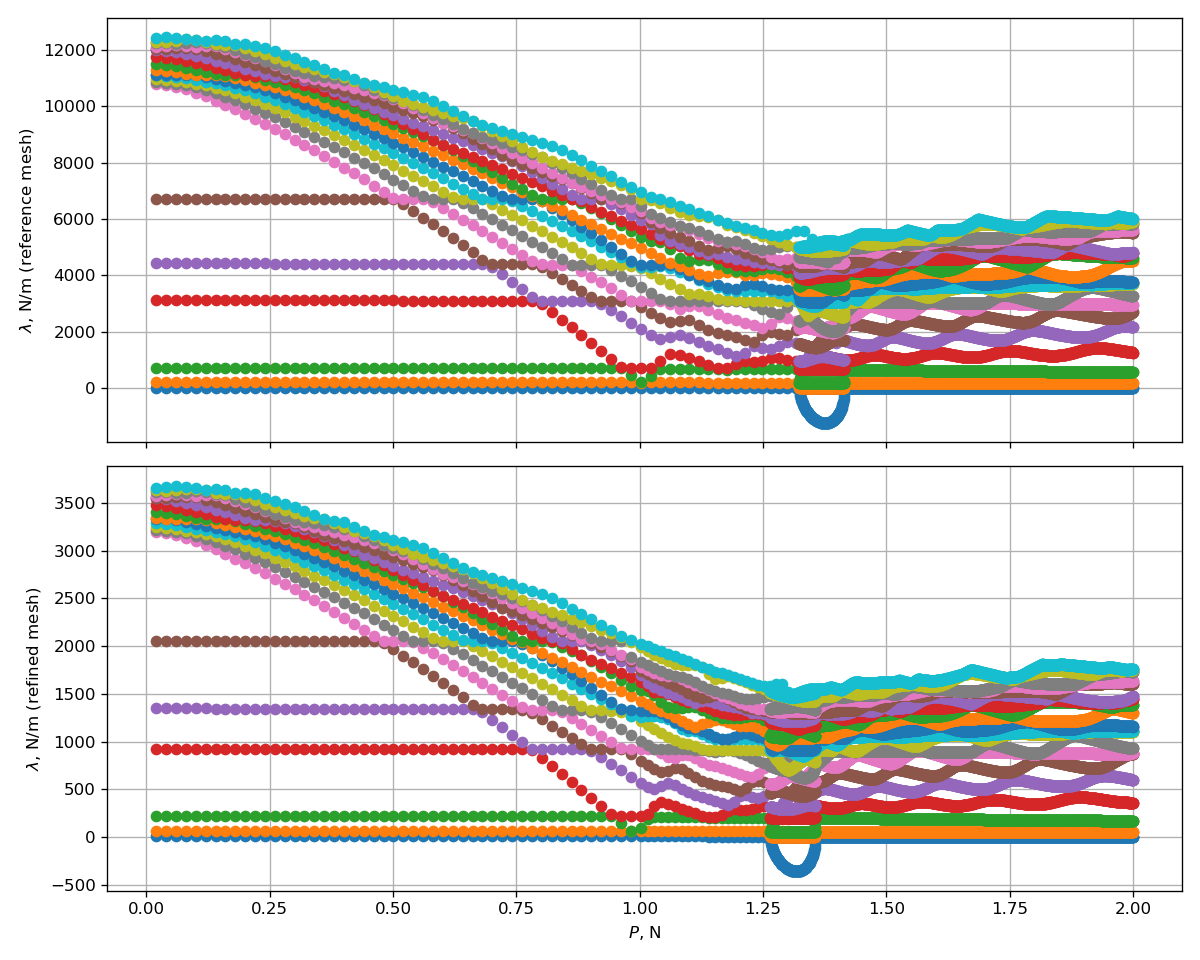

In [244]:
# Read eigenvalues obtained with refence mesh
f06_path = os.path.join(analysis_directory_path, input_name_reference_mesh + ".f06")  # path to .f06 file
eigenvalues_reference_mesh = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Read eigenvalues obtained with refined mesh
f06_path = os.path.join(analysis_directory_path, input_name_refined_mesh + ".f06")  # path to .f06 file
eigenvalues_refined_mesh = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Plot for refence mesh
ax1.plot(nondimensional_applied_loads["reference mesh"], eigenvalues_reference_mesh.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax1.set_ylabel("$\lambda$, N/m (reference mesh)")
ax1.grid(True)

# Plot for the refined mesh
ax2.plot(nondimensional_applied_loads["refined mesh"], eigenvalues_refined_mesh.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax2.set_xlabel("$P$, N")
ax2.set_ylabel("$\lambda$, N/m (refined mesh)")
ax2.grid(True)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

The eigenvalues show indeed a stable equilibrium for the first segment of the paths, corresponding to the broken-bifurcation-like behavior, while one eigenvalue becomes negative at an applied load of $P/P_\mathrm{SOL 105}=0.5$, corresponding to the limit point, meaning that the structure becomes unstable. All eigenvalues turn again positive at an applied load of $P/P_\mathrm{SOL 105}=0.6$, indicating that the box beam has regained stability.

Let's plot only the eigenvalues of the box beam with the reference mesh.

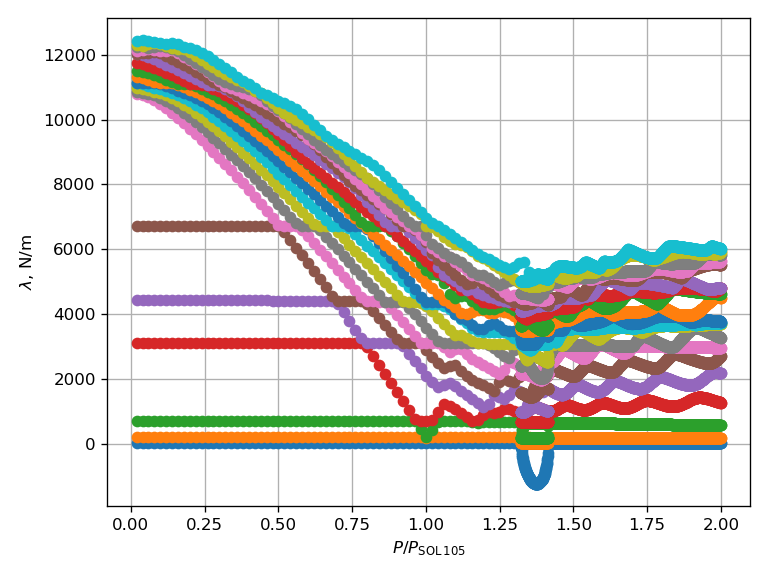

In [245]:
# Read eigenvalues obtained with refence mesh
f06_path = os.path.join(analysis_directory_path, input_name_reference_mesh + ".f06")  # path to .f06 file
eigenvalues_reference_mesh = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Create the figure
plt.figure()

# Plot for refence mesh
plt.plot(nondimensional_applied_loads["reference mesh"], eigenvalues_reference_mesh.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
plt.ylabel("$\lambda$, N/m")
plt.xlabel("$P/P_\mathrm{SOL\/105}$")
plt.grid(True)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

Let's plot the 3D equilibrium diagram of the box beam employing the reference mesh to visualize the glass ceiling of linear buckling and the limit point.

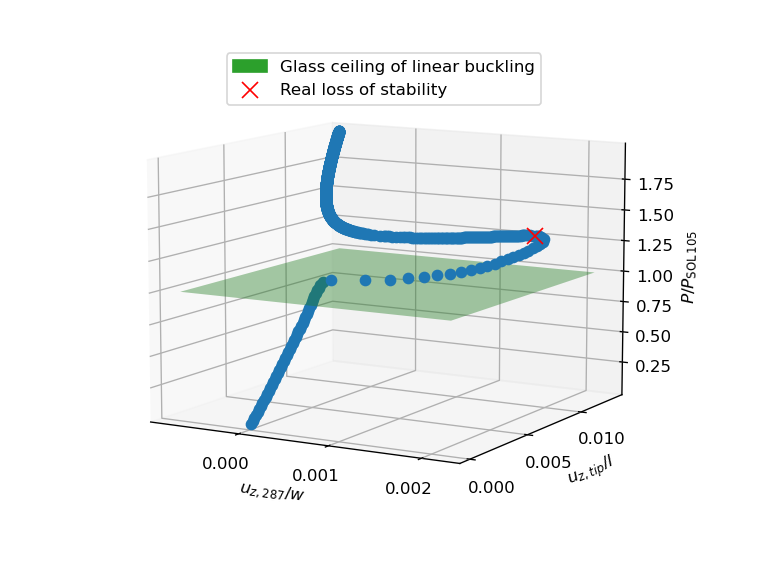

In [246]:
# Create figure with three-dimensional axes
plt.figure()
ax_3d = plt.axes(projection="3d")

# Plot part of the equilibrium paths that should not be visible on top of the plane
load_factor = 1
key = "reference mesh"
ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key]<load_factor, nondimensional_applied_loads[key], np.nan),
                 "o", color=colors[0])

# Plot plane
xx, yy = np.meshgrid([np.min(nondimensional_local_displacements[key]), np.max(nondimensional_local_displacements[key])],
                     [np.min(nondimensional_tip_displacements[key]), np.max(nondimensional_tip_displacements[key])])
ax_3d.plot_surface(xx, yy, np.full_like(xx, load_factor), alpha=0.4, color=colors[2])
import matplotlib.patches as mpatches
proxy_surface = mpatches.Patch(color=colors[2], label="Glass ceiling of linear buckling")

# Plot part of the equilibrium paths that should be visible on top of the plane
ax_3d.plot3D(nondimensional_local_displacements[key], nondimensional_tip_displacements[key],
                 np.where(nondimensional_applied_loads[key]>=load_factor, nondimensional_applied_loads[key], np.nan),
                 "o", color=colors[0], zorder=3)

# Find first index where lowest eigenvalue is negative
first_negative_eigenvalue_index = np.where(eigenvalues_reference_mesh < 0)[1][0]
# Plot point where lowest eigenvalue is negative
ax_3d.plot3D(nondimensional_local_displacements[key][first_negative_eigenvalue_index], nondimensional_tip_displacements[key][first_negative_eigenvalue_index],
             nondimensional_applied_loads[key][first_negative_eigenvalue_index], "x", markersize=10,color="red", zorder=4)
import matplotlib.lines as mlines
proxy_point = mlines.Line2D([], [], color='red', marker='x', markersize=10, label="Real loss of stability", linestyle='None')
             
# Set plot appearance
ax_3d.view_init(10, -60)
ax_3d.set_xlabel(f"$u_{{z, {max_displacement_node_id:d}}}/w$")
ax_3d.set_ylabel("$u_{z, tip}/l$")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.locator_params(axis="x", nbins=5)  # set number of ticks of x-axis
ax_3d.locator_params(axis="y", nbins=5)  # set number of ticks of z-axis
ax_3d.grid(visible=True)
plt.legend(handles=[proxy_surface, proxy_point], bbox_to_anchor=(0.5, .95), loc='upper center')
plt.tight_layout()
plt.show()

Finally it's interesting to visualize deformation shape before and after the limit point, to observe what part of the box beam is involved in the snap-through. We then select three points of the equilibrium diagram, one at $P/P_\mathrm{SOL 105}=0.5$, to visualize the deformation in the linear range for reference, and then the point just before the loss of stability and just after the snap. We plot only the deformed shape of the reference model and we amplify the displacements by a factor 50 for visualization purposes.

Deformation at P/P_SOL 105 = 0.5:


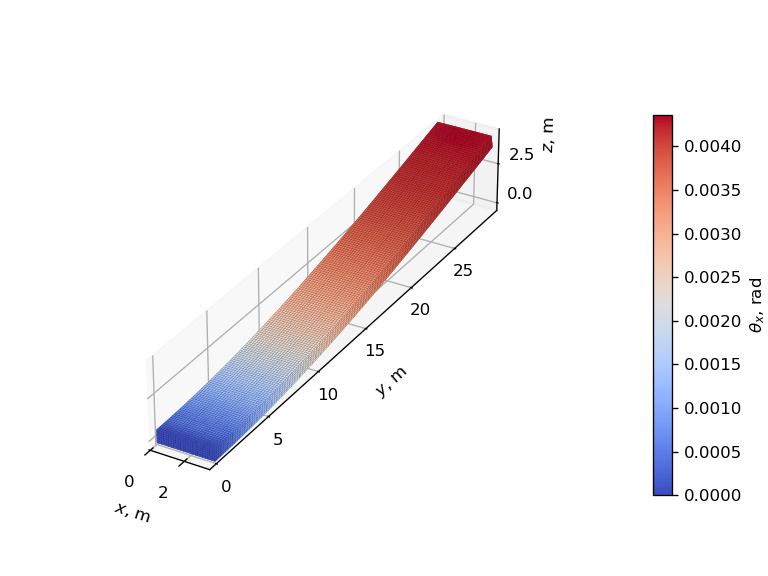

Deformation at P/P_SOL 105 = 1.41:


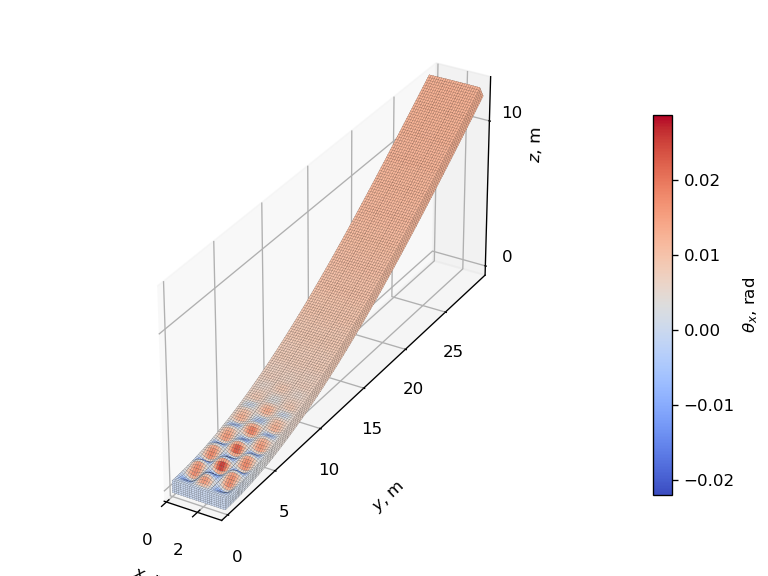

Deformation at P/P_SOL 105 = 1.41:


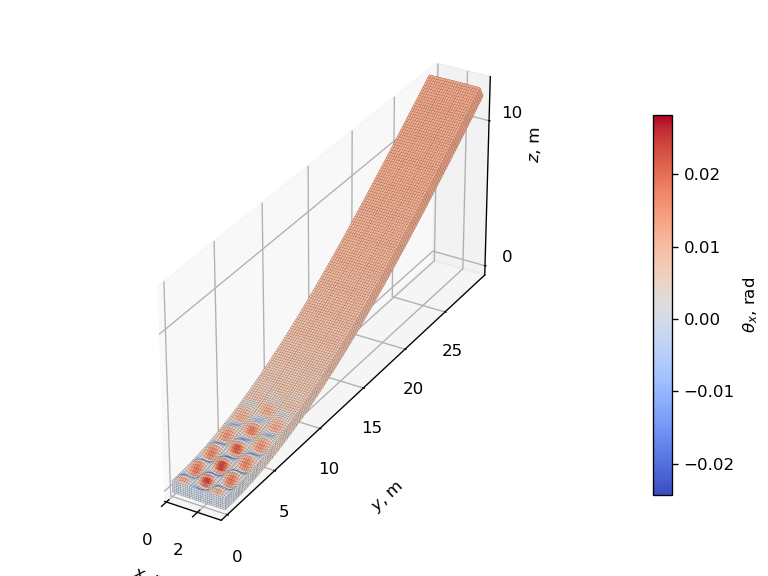

In [247]:
# Find closest converged iteration to applied load before limit point
nondimensional_applied_load_before_limit_point = .5
converged_itearation = np.argmin(np.abs(nondimensional_applied_loads["reference mesh"] - nondimensional_applied_load_before_limit_point)) + 1  # converged iteration number corresponding to applied load before limit point

# Plot deformation before limit point
print("Deformation at P/P_SOL 105 = 0.5:")
amplification_factor = 50  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_reference_mesh, subcase_id=loading_subcase_id, load_step=converged_itearation,
                                                      displacement_component="rx", colormap="coolwarm", length_unit="m", unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()
# plt.savefig("deformation0_5.png", dpi=300)

# Plot deformation just before limit point
nondimensional_applied_load_before_limit_point = nondimensional_applied_loads["reference mesh"][first_negative_eigenvalue_index-1]
print(f"Deformation at P/P_SOL 105 = {nondimensional_applied_load_before_limit_point:.2f}:")
# amplification_factor = 50  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_reference_mesh, subcase_id=loading_subcase_id, load_step=first_negative_eigenvalue_index,
                                                      displacement_component="rx", colormap="coolwarm", length_unit="m", unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
# ax.set_xlim(0, w*1e-3)
# ax.set_ylim(0, 4*h*1e-3)
# ax.set_zlim(-h/2*1e-3, h*1e-3)
# ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
# plt.axis("off")
# ax.view_init(40, -20)
plt.show()
# plt.savefig("deformation_before_limit_point.png", dpi=300)

# Find closest converged iteration to applied load after limit point
subsequent_values = nondimensional_applied_loads[key][first_negative_eigenvalue_index + 10:]
closest_index_in_subsequent = np.argmin(np.abs(subsequent_values - nondimensional_applied_load_before_limit_point))
closest_index = first_negative_eigenvalue_index + closest_index_in_subsequent
nondimensional_applied_load_after_limit_point = nondimensional_applied_loads["reference mesh"][closest_index]
print(f"Deformation at P/P_SOL 105 = {nondimensional_applied_load_after_limit_point:.2f}:")

# Plot deformation after limit point
_, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_reference_mesh, subcase_id=loading_subcase_id, load_step=closest_index + 1,
                                                      displacement_component="rx", colormap="coolwarm", length_unit="m", unit_scale_factor=1e-3,
                                                      displacement_amplification_factor=amplification_factor)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
# ax.set_xlim(0, w*1e-3)
# ax.set_ylim(0, 4*h*1e-3)
# ax.set_zlim(-h/2*1e-3, h*1e-3)
# ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
# plt.axis("off")
# ax.view_init(40, -20)
plt.show()
# plt.savefig("deformation_after_limit_point.png", dpi=300)

The deformation shape before the limit point is characterized by the prefence of one half-wave for each rib-stiffener bay between the root and first rib, and by the presence of two half-waves per rib-stiffener bay between the successive ribs. After the limit point, the half-wave between the root and the first rib is transformed into two half-waves for each rib-stiffener bay, while the rib-stiffener bays betwen successive ribs keep the same number of half-waves.

## Nonlinear analysis: sensitivity of nonlinear analysis parameters <a name="nonlinear-analysis-parameters"></a>

***

Now we want to assess the influence of SOL 106's nonlinear analysis parameters on the results of the analysis, and possibly find some of the complementary paths while doing so. Similarly to our previous box beam versions, we apply twice the buckling load predicted by SOL 105, vary several parameters of the NLPARM and the NLPCI cards and look at how the load-displacement diagram changes.

We don't need to define a new `BDF` object, since we can reuse the one of the previous section, created with the mesh obtained from the convergence study. We only need to define new NLPARM and NLPCI cards with default parameters, and to assign those to the first subcsase. We know that the default parameters imply a coarse arc-length step size, and we are going to use this property to verify whether the solver jumps to a complementary path.

In [248]:
coarse_nlparm_id = 2
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, nlparm_id=coarse_nlparm_id, subcase_id=loading_subcase_id)

To monitor how the nonlinear analysis parameters affect the results, we want to observe how the followed equilibrium paths change. In our previous notebooks we have always plotted the load-displacement diagram in terms of applied loads versus tip displacements. However, given the complexity of the natural equilibrium path of the present box beam, plotting only those two quantities is probably not going to be much descriptive. For this reason, this time we monitor the changes in the 3D equilibrium diagram, where we use the usual combination of nondimensional local displacement, tip displacement and applied load.

Consequently, we define the function `plot_load_displacement_curve`, which runs the Nastran analysis, reads the displacement and load history from the op2 file and plots the corresponding load-displacement curve on a pre-defined figure, nondimensionalizing the local displacement with the width of the box beam, tip displacement with the length, and the applied load with the buckling load predicted by SOL 105.

In [249]:
def plot_load_displacement_curve(bdf_input, filename, axes, subcase_id, marker_style, line_label, run_flag=False):
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=filename, run_flag=run_flag)
    # Read load and displacement history from op2 file
    op2_path = os.path.join(analysis_directory_path, filename + '.op2')
    op2 = read_op2(op2_path, debug=None)
    _, p, tip_disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=tip_master_node_id)
    _, _, local_disp = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2, displacement_node_id=max_displacement_node_id)
    # Plot load-displacement curve on input axes
    axes.plot3D(local_disp[subcase_id][:, component_index]/w, tip_disp[subcase_id][:, component_index]/l, p[subcase_id][:, component_index]/sol_105_buckling_load,
                marker_style, label=line_label)

### Error function <a name="error-function"></a>

We start our sensitivity study by looking at the error function. We consider four different combinations of error functions:
- load and energy (default);
- load and displacement with vector component checking;
- load, energy and displacement;
- load, energy and displacement with vector component checking. 

In [250]:
error_functions = ['PW', 'PUV', 'PWU', 'PWUV']

Since we want to compare the results with the natural equilibrium path, we define a function that creates a new figure and plots the natural equilibrium path on the 3D equilibrium diagram. We'll call this function before running our analyses and plotting the resulting load-displacement curves.

In [251]:
def plot_natural_equilibriunm_path():
    # Create 3D plot of equilibrium diagram
    plt.figure()
    axes = plt.axes(projection="3d")
    axes.plot3D(nondimensional_local_displacements["reference mesh"], nondimensional_tip_displacements["reference mesh"], nondimensional_applied_loads["reference mesh"],
                "o", label="Natural path")
    # Set plot appearance
    axes.set_xlabel(f"$u_{{z, {max_displacement_node_id:d}}}/w$")
    axes.set_ylabel("$u_{z, tip}/l$")
    axes.set_zlabel("$P/P_\mathrm{SOL\/105}$")
    axes.grid(visible=True)
    # Return axes object
    return axes

Let's plot the natural equilibrium path, run the analyses with the different error functions and plot the results.

Nastran job nonlinear_analysis_error_function_PW.bdf completed
Wall time: 129.0 s


Nastran job nonlinear_analysis_error_function_PUV.bdf completed
Wall time: 126.0 s


Nastran job nonlinear_analysis_error_function_PWU.bdf completed
Wall time: 135.0 s


Nastran job nonlinear_analysis_error_function_PWUV.bdf completed
Wall time: 133.0 s


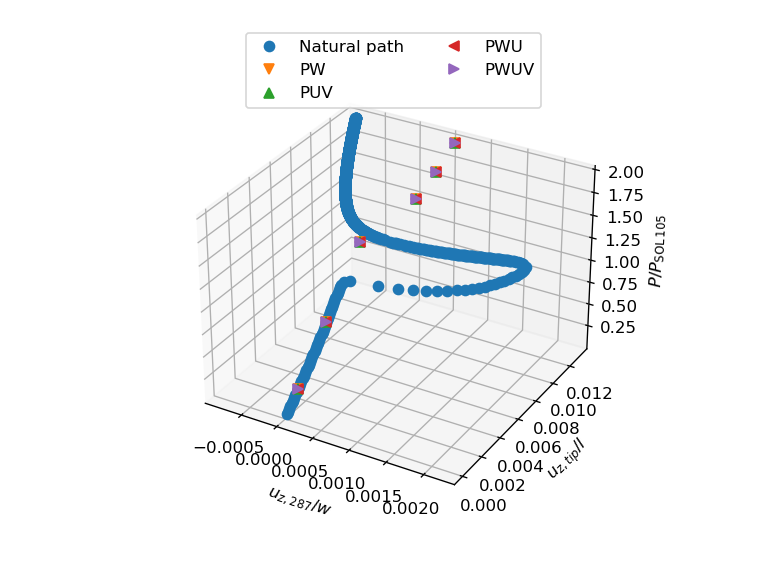

In [252]:
# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis for each set of error functions and plot load-displacement curve
for count, fun in enumerate(error_functions):
    box_beam_bdf.nlparms[coarse_nlparm_id].conv = fun
    input_filename = "nonlinear_analysis_error_function_" + fun
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1], f"{fun}", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2)
plt.show()

The different analyses appear to converge to the exact same equilibrium points. However, only the first two appear to be on the natural equilibrium path, and as soon as the first nonlinearity of the natural path is reached, the solver seems to jump to points belonging to one or more complementary paths. We then investigate the presence of a complementary path by unloading the structure from the final point of one of the analyses with fine arc-length step size.

We restore the default error function, define a second subcase with zero applied load, assign the NLPARM and NLPCI cards with fine arc-length step size settings and run the analysis.

In [253]:
box_beam_bdf.nlparms[coarse_nlparm_id].conv = 'PW'  # restore default error function

# Define second subcase
zero_load_set_id = load_set_id + 1  # id of LOAD card
box_beam_bdf.add_load(zero_load_set_id, scale=1., scale_factors=[0.], load_ids=[force_set_id])  # add LOAD card with zero applied load
unloading_subcase_id = 2  # id of second subcase
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=unloading_subcase_id, load_set_id=zero_load_set_id)  # create subcase with zero applied load
box_beam_bdf.case_control_deck.subcases[unloading_subcase_id].add_integer_type('NLPARM', fine_nlparm_id)  # use NLPARM with fine arc-length method parameters in second subcase

# Run analysis
analysis_label = "pw"
input_name = "equilibrium_path_verification_" + analysis_label
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

Nastran job equilibrium_path_verification_pw.bdf completed
Wall time: 1005.0 s


Let's read the load and displacement history from the `OP2` object and plot together the path followed in the second subcase and the natural equilibrium path.

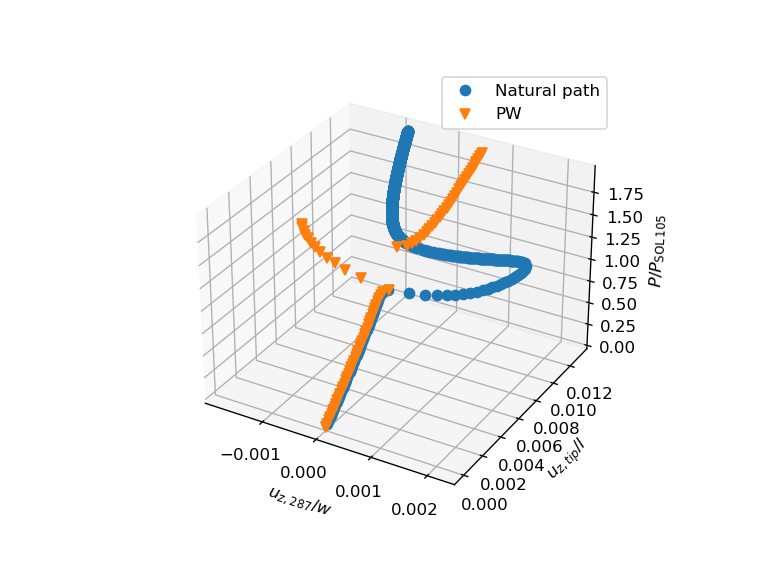

In [254]:
# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Read load and displacement history and plot load-displacement curve of second subcase
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=tip_master_node_id)
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=max_displacement_node_id)
ax.plot3D(local_displacements[unloading_subcase_id][:, component_index]/w, tip_displacements[unloading_subcase_id][:, component_index]/l,
            applied_loads[unloading_subcase_id][:, component_index]/sol_105_buckling_load, markers[1], label="PW")

# Show plot
ax.legend()
plt.show()

What is happening in the orange curve? The arc-length solver starts from the final equilibrium point of the first subcase and unloads the structure following the equilibrium path down to approximately $P/P_\mathrm{SOL\,105}=1.28$, where it jumps to another path. On this path the solver keeps unloading the structure down to $P/P_\mathrm{SOL\,105}=0.98$, where it finally jumps to the natural path and follows it down to zero load.

Let's have a look at the eigenvalues of the tangent stiffness matrix along this paths.

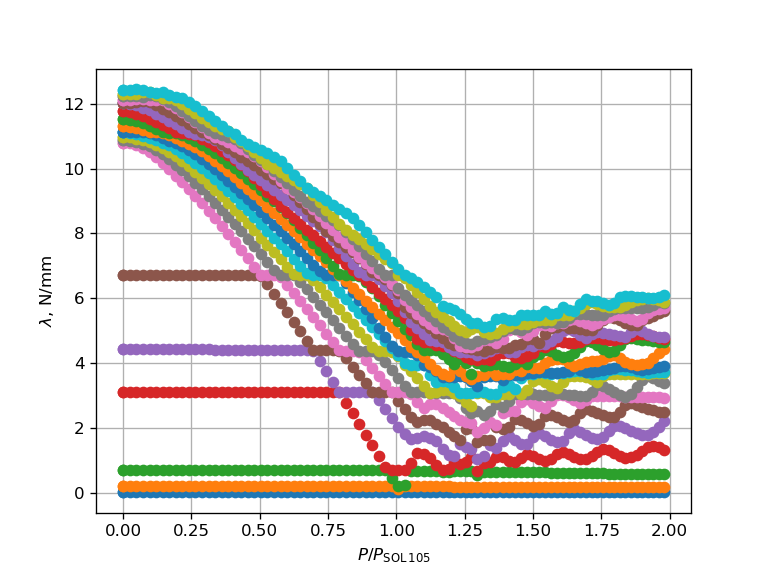

In [255]:
# Read eigenvalues from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_name + ".f06")
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Extract eigenvalues for the given subcase
no_load_steps = len(applied_loads[unloading_subcase_id])
start_index = sum(len(applied_loads[subcase_id]) for subcase_id in applied_loads if subcase_id < unloading_subcase_id)
eigenvalues_for_subcase = eigenvalues[:, start_index:start_index + no_load_steps]

# Plot eigenvalues vs applied load
plt.figure()
plt.plot(applied_loads[unloading_subcase_id][:eigenvalues_for_subcase.shape[1], component_index] / sol_105_buckling_load,
         eigenvalues_for_subcase.T, "o")

# Set plot appearance
plt.xlabel('$P/P_\mathrm{SOL\/105}$')
plt.ylabel('$\lambda$, N/mm')
plt.grid(visible=True)
plt.show()

The eigenvalues show that all the equilibrium points found by the arc-length solver are stable. So, why do we observe the two jumps?

The arc-length method is a predictor-corrector method, meaning that it first predicts the next equilibrium point and then corrects it to obtain the actual equilibrium point. The prediction is based on the tangent stiffness matrix, which is calculated at the previous equilibrium point. If the structure is highly nonlinear around the current point, the predictor step may land relatively far from the current path. In the event that the predictor step lands closer to a different path, the corrector step will make the solver converge to this new path instead of the old path. This is what may be happening in our case, with solver jumping to stable segments of different equilibrium path.

At this point, we turn our attention at the diagnostic messages printed for each iteration in the f06 file to find some clues that may confirm our hypothesis.

We notice that all converged iterations achieve convergence in 2 or 3 iterations, except for the two instances where the solver jumps to a different path. In these cases the solver takes 8 and 4 iterations to converge. This suggests that the solver is having more difficulties in converging to the equilibrium points corresponding to the jumps. A possible explanation for this is that when the predictor step lands closer to a different path, it is unlikely that it lands very close to such path, allowing the corrector step to converge in few iterations. In other words, when the predictor step moves away from the current path, it can get closer to a different path but it will probably land relatively far from both paths, making the corrector step converge in more iterations.

For this reason, we repeat the analysis with the following strategy: we limit the maximum number of iterations for each step to 3 and we increase the maximum number of bisections to 20, so that the solver can halve the step size as many times as needed to converge in maximum 3 iterations.

Let's modify the NLPARM and NLPCI card of the second subcase, run the analysis and plot the results.

Nastran job equilibrium_path_verification_pw_maxiter3.bdf completed
Wall time: 10465.0 s


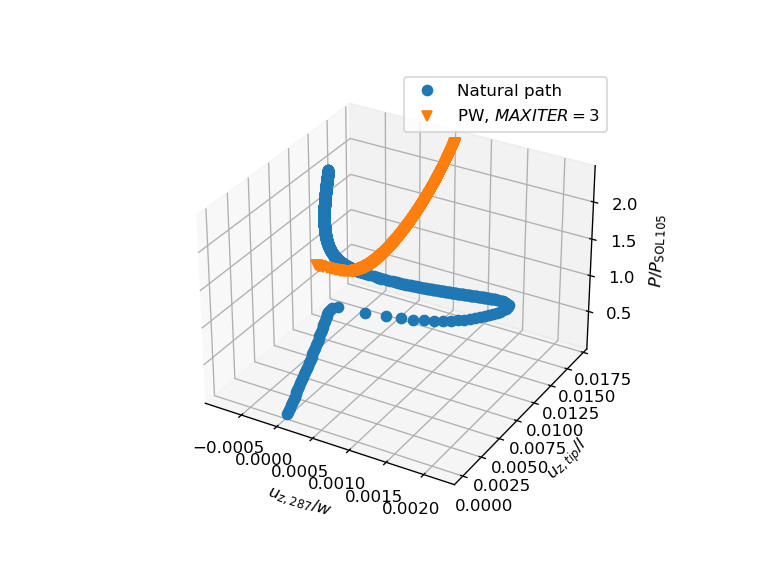

In [256]:
# Change nonlinear analysis parameters of second subcase
box_beam_bdf.nlparms[fine_nlparm_id].max_iter = 3  # set maximum number of iterations to 3
box_beam_bdf.nlparms[fine_nlparm_id].max_bisect = 20  # set maximum number of bisections to 20


# Run analysis
analysis_label = "pw_maxiter3"
input_name = "equilibrium_path_verification_" + analysis_label
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Read load and displacement history and plot load-displacement curve of second subcase
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=tip_master_node_id)
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=max_displacement_node_id)
ax.plot3D(local_displacements[unloading_subcase_id][:, component_index]/w, tip_displacements[unloading_subcase_id][:, component_index]/l,
            applied_loads[unloading_subcase_id][:, component_index]/sol_105_buckling_load, markers[1], label="PW, $MAXITER=3$")

# Show plot
ax.legend()
plt.show()

Let's try with $MAXITER=2$.

Nastran job equilibrium_path_verification_pw_maxiter2.bdf completed
Wall time: 10642.0 s


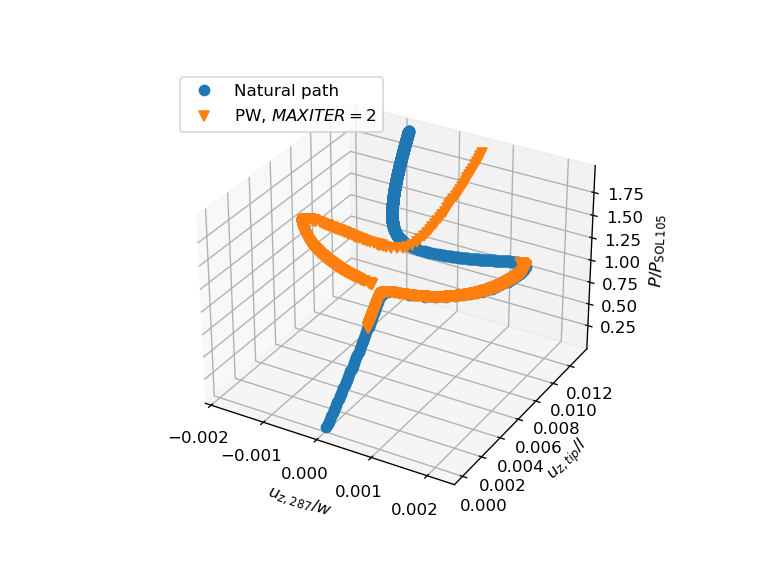

In [257]:
# Change nonlinear analysis parameters of second subcase
box_beam_bdf.nlparms[fine_nlparm_id].max_iter = 2  # set maximum number of iterations to 2

# Run analysis
analysis_label = "pw_maxiter2"
input_name = "equilibrium_path_verification_" + analysis_label
sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=method_set_id, no_eigenvalues=no_eigenvalues,
    analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Read load and displacement history and plot load-displacement curve of second subcase
_, applied_loads, tip_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=tip_master_node_id)
_, _, local_displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2, displacement_node_id=max_displacement_node_id)
ax.plot3D(local_displacements[unloading_subcase_id][:, component_index]/w, tip_displacements[unloading_subcase_id][:, component_index]/l,
            applied_loads[unloading_subcase_id][:, component_index]/sol_105_buckling_load, markers[1], label="PW, $MAXITER=2$")

# Show plot
ax.legend()
plt.show()

### Convergence tolerance <a name="convergence-tolerance"></a>

The second parameter that we consider is the convergence tolerance. Let's take three different combinations of load and energy tolerances, taken from [table 21](https://help.hexagonmi.com/bundle/MSC_Nastran_2021.4/page/Nastran_Combined_Book/qrg/bulkno/TOC.NLPARM.xhtml) of MSC Nastran *Quick Reference Guide* manual on the default tolerances for static nonlinear SOL 106 models:
- $EPSP=10^{-1}$, $EPSW=10^{-1}$;
- $EPSP=10^{-2}$, $EPSW=10^{-3}$;
- $EPSP=10^{-3}$, $EPSW=10^{-7}$,

where the default values are $EPSP=10^{-2}$ and $EPSW=10^{-2}$.

Let's define the list of convergence tolerances, run the analyses and visualize the results.

Nastran job nonlinear_analysis_epsp1e-01.bdf completed
Wall time: 228.0 s


Nastran job nonlinear_analysis_epsp1e-02.bdf completed
Wall time: 115.0 s


Nastran job nonlinear_analysis_epsp1e-03.bdf completed
Wall time: 210.0 s


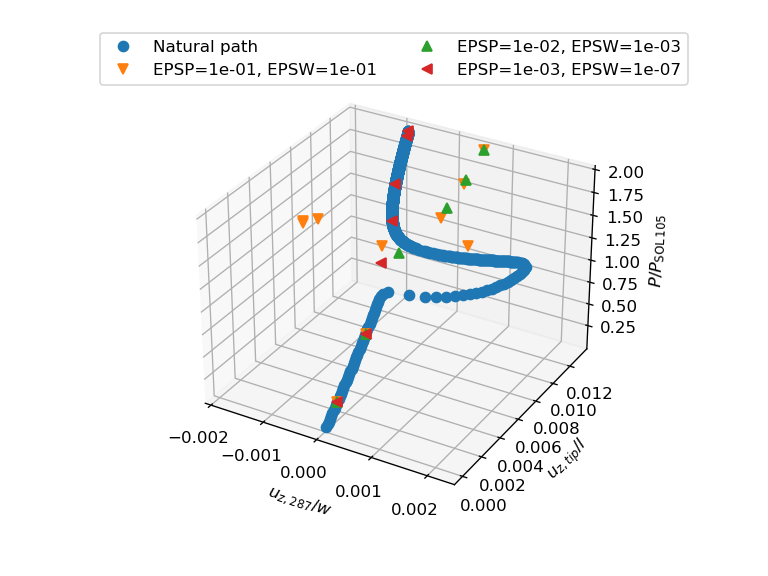

In [259]:
# Remove second subcase
del box_beam_bdf.subcases[unloading_subcase_id]

# Define error tolerances
load_tolerances = [1e-1, 1e-2, 1e-3]
work_tolerances = [1e-1, 1e-3, 1e-7]

# Plot natural equilibrium path
ax = plot_natural_equilibriunm_path()

# Run analysis for each set of convergence tolerances and plot load-displacement curve
for count, epsp in enumerate(load_tolerances):
    epsw = work_tolerances[count]
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_p = epsp
    box_beam_bdf.nlparms[coarse_nlparm_id].eps_w = epsw
    input_filename = f"nonlinear_analysis_epsp{epsp:.0e}"
    plot_load_displacement_curve(box_beam_bdf, input_filename, ax, loading_subcase_id, markers[count + 1], f"EPSP={epsp:.0e}, EPSW={epsw:.0e}", run_flag=False)

# Show plot
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2)
plt.show()

Work in progress.